Load data.

In [1]:
### LINES TO IMPORT THE DECONFOUNDER PACKAGE IN THE PARENT FOLDER ###
import os
import sys
sys.path.append("..")
### IMPORTS
from deconfounder.causal_tree import CausalTree
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import time

# Load data
df = pd.read_csv("../data/criteo-uplift-v2.1.csv")
df = df.sample(frac=1, random_state=42)
all_features = df.columns.values[:12].tolist()

We will use an experimental size of 50,000: it has a significance level of 0.1%.

In [159]:
exp_size = 50000
treated_ratio = 0.85 # same as in data
means = df.groupby('treatment').visit.mean()
variances = df.groupby('treatment').visit.var()
standard_error = np.sqrt(variances[1]/(exp_size*treated_ratio) + variances[0]/(exp_size*(1-treated_ratio)))
avg_effect = (means[1] - means[0])
p_value = (st.norm.cdf(-avg_effect/standard_error))*2
print(f"Average effect (entire sample): {round(avg_effect*100, 2)}%")
print(f"Standard error with sample size of {exp_size:,}: {round(standard_error*100, 2)}%")
print(f"p-value: {round(p_value, 4)}")

Average effect (entire sample): 1.03%
Standard error with sample size of 50,000: 0.24%
p-value: 0.0


Obtain experimental data.

In [3]:
def print_outcomes(data):
    means = data.groupby('treatment').visit.mean()
    print(f"Avg. Outcome (treated): {np.round(means.loc[1]*100, 2)}%")
    print(f"Avg. Outcome (control): {np.round(means.loc[0]*100, 2)}%")
    print(f"Estimated avg. effect: {np.round((means.loc[1]-means.loc[0])*100, 2)}%")

exp_df = df[0:exp_size]
print_outcomes(exp_df)

Avg. Outcome (treated): 4.86%
Avg. Outcome (control): 4.06%
Estimated avg. effect: 0.8%


Find the feature that is correalted the most with the outcome and remove that feature (i.e., the confounder).

In [6]:
corr_matrix = df[all_features + ['visit']].corr()
confounder = corr_matrix['visit'][:-1].sort_values().index.values[-1]
print(confounder)
limited_features = list(all_features)
limited_features.remove(confounder)

f9


Obtain observational data. Drop observations using the confounder.

In [7]:
train_frac = 0.5
train_size = int(df.shape[0]*train_frac)
obs_df = df[:train_size]
drop_frac = 0.1

conf_ranking = obs_df[confounder].rank(method="first")
keep =  ((obs_df.treatment == 1) & (conf_ranking > int(train_size * drop_frac))) | \
        ((obs_df.treatment == 0) & (conf_ranking < int(train_size * (1 - drop_frac))))
obs_df = obs_df[keep]
print(f"Size of observational data: {obs_df.shape[0]:,}")
print_outcomes(obs_df)

Size of observational data: 6,297,527
Avg. Outcome (treated): 5.31%
Avg. Outcome (control): 1.23%
Estimated avg. effect: 4.08%


Obtain evaluation data

In [8]:
eval_df = df[train_size:].copy()

Evaluate ad-hoc policy used to generate confounding (interesting: actually good for treatment assignment).

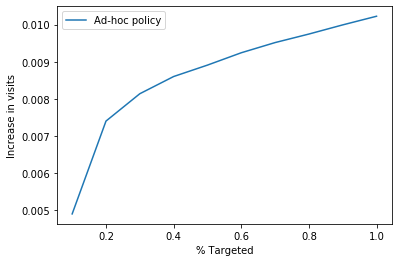

In [200]:
def evaluate(e_df, title):
    e_df = e_df.sort_values('pred', ascending=False)
    cum_per = np.arange(e_df.shape[0]) / e_df.shape[0]
    fractions = []
    effects = []
    size = 10
    for i in range(size):
        targeted = cum_per < (i+1)/size
        fraction = targeted.mean()
        avg_outcomes = e_df[targeted].groupby('treatment').visit.mean()
        effect = (avg_outcomes.loc[1] - avg_outcomes.loc[0]) * fraction
        fractions.append(fraction)
        effects.append(effect)
    plt.plot(fractions, effects, label=title)
    plt.xlabel("% Targeted")
    plt.ylabel("Increase in visits")
    plt.legend()

eval_df['pred'] = eval_df[confounder]
evaluate(eval_df, "Ad-hoc policy")
plt.show()

Train policy with experimental data.

In [201]:
def fit_causal_tree(df_causal, min_samples_leaf=5000, tune=False):    
    X = df_causal[limited_features + ['treatment']].rename(columns={"treatment":"treated"})
    y =  df_causal.visit
    # Fit and tune causal tree
    start_time = time.time()
    if tune:
        tuned_parameters = [{'min_samples_leaf': range(1000, 10000, 1000)}]
        grid_tree = GridSearchCV(CausalTree(random_state=42), tuned_parameters, cv=5)
        grid_tree.fit(X, y)
        print("Best parameters set found on development set:")
        print(grid_tree.best_params_)
        causal_tree = grid_tree.best_estimator_
    else:
        causal_tree = CausalTree(min_samples_leaf=min_samples_leaf, random_state=42)
        causal_tree.fit(X, y)   
    print("--- Time to fit (and tune) causal tree %s seconds ---" % (time.time() - start_time))
    return causal_tree

exp_tree = fit_causal_tree(exp_df, tune=True)

Best parameters set found on development set:
{'min_samples_leaf': 7000}
--- Time to fit (and tune) causal tree 4.569194793701172 seconds ---


Evaluate model with experimental data.

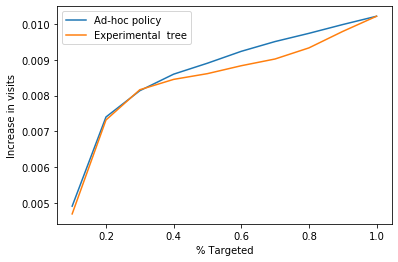

In [213]:
eval_df['pred'] = eval_df[confounder]
evaluate(eval_df, "Ad-hoc policy")
exp_preds = exp_tree.predict(eval_df[limited_features])
eval_df['pred'] = exp_preds
evaluate(eval_df, "Experimental  tree")
plt.show()

Train policy with observational data.

In [12]:
obs_tree = fit_causal_tree(obs_df, min_samples_leaf=exp_tree.min_samples_leaf)

--- Time to fit (and tune) causal tree 88.94420742988586 seconds ---


Obtain estimates after accounting for observed confounding (much more worse results than in the experiment).

In [14]:
preds = obs_tree.predict(eval_df[limited_features])
print(f"Estimated avg. effect: {np.round(preds.mean()*100, 2)}%")

Estimated avg. effect: 2.83%


Evaluate policy with observational data.

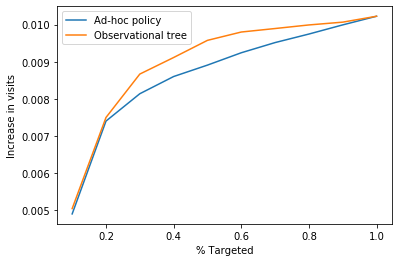

In [203]:
eval_df['pred'] = eval_df[confounder]
evaluate(eval_df, "Ad-hoc policy")
eval_df['pred'] = obs_tree.predict(eval_df[limited_features])
evaluate(eval_df, "Observational tree")
plt.show()

# Approach 1: Are outcomes and effects correlated?

Build a decision tree for the untreated.

In [20]:
# Build a decision tree for the untreated
from sklearn.tree import DecisionTreeClassifier

def fit_decision_tree(df_causal, min_samples_leaf=5000, tune=False):    
    X = df_causal[limited_features + ['treatment']].rename(columns={"treatment":"treated"})
    y =  df_causal.visit
    # Fit and tune causal tree
    start_time = time.time()
    if tune:
        tuned_parameters = [{'min_samples_leaf': range(1000, 10000, 1000)}]
        grid_tree = GridSearchCV(DecisionTreeClassifier(random_state=42), tuned_parameters, cv=5)
        grid_tree.fit(X, y)
        print("Best parameters set found on development set:")
        print(grid_tree.best_params_)
        decision_tree = grid_tree.best_estimator_
    else:
        decision_tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, random_state=42)
        decision_tree.fit(X, y)   
    print("--- Time to fit (and tune) causal tree %s seconds ---" % (time.time() - start_time))
    return decision_tree

df_train = df[:train_size]
print("Outcome Tree")
outcome_tree = fit_decision_tree(df_train, min_samples_leaf=exp_tree.min_samples_leaf)
print("Oracle Tree")
oracle_tree = fit_causal_tree(df_train, min_samples_leaf=exp_tree.min_samples_leaf)

--- Time to fit (and tune) causal tree 90.76679873466492 seconds ---


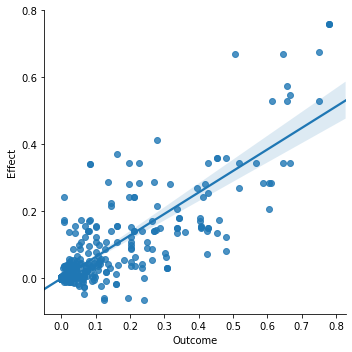

In [82]:
import seaborn as sns

outcome_preds = outcome_tree.predict_proba(eval_df[limited_features + ['treatment']])[:, 1]
obs_preds = obs_tree.predict(eval_df[limited_features])
df_pred = pd.DataFrame({"Outcome": outcome_preds, "Effect": obs_preds})
sns.lmplot(x='Outcome',y='Effect',data=df_pred.sample(1000, random_state=42),fit_reg=True) 

In [86]:
from scipy.stats import spearmanr
print(spearmanr(obs_preds, outcome_preds))
print(np.corrcoef(obs_preds, outcome_preds)[0, 1])

SpearmanrResult(correlation=0.6496374344205044, pvalue=0.0)
0.8635959862413352


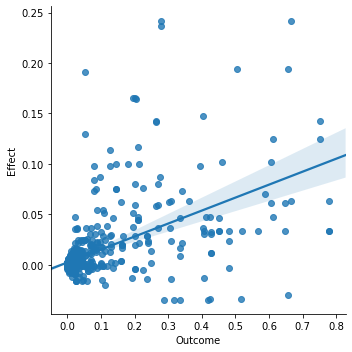

In [87]:
oracle_preds = oracle_tree.predict(eval_df[limited_features])
df_pred = pd.DataFrame({"Outcome": outcome_preds, "Effect": oracle_preds})
sns.lmplot(x='Outcome',y='Effect',data=df_pred.sample(1000, random_state=42),fit_reg=True) 

In [88]:
print(spearmanr(oracle_preds, outcome_preds))
print(np.corrcoef(oracle_preds, outcome_preds)[0, 1])

SpearmanrResult(correlation=0.43377737467448696, pvalue=0.0)
0.5560750918089633


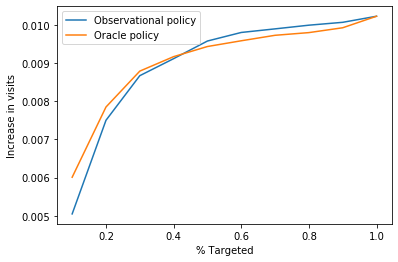

In [211]:
eval_df['pred'] = obs_preds
evaluate(eval_df, "Observational policy")
eval_df['pred'] = oracle_preds
evaluate(eval_df, "Oracle policy")
plt.show()

# Approach 2: Who are the profitable customers?

In [103]:
from sklearn.model_selection import cross_val_predict

X = obs_df[limited_features + ['treatment']].rename(columns={"treatment":"treated"})
y =  obs_df.visit
cross_preds = cross_val_predict(CausalTree(min_samples_leaf=exp_tree.min_samples_leaf, random_state=42), X, y, cv=5)

Only lose money if the bias is at least 5 times the effect.

In [170]:
obs_effect_estimations = obs_tree.predict(obs_df[limited_features])
visit_value = 0.5
ad_cost = 0.01
boundary = ad_cost/(visit_value+ad_cost)
targeted = cross_preds > boundary
biased_avg_effect = obs_effect_estimations.mean()
total_impressions = 1000000

real_avg_bias = round(1 - avg_effect/biased_avg_effect, 2)

for bias_rel_size in (0, 0.5, 1, 2, 3, 4, 5, real_avg_bias):
    if bias_rel_size == real_avg_bias:
        print("REAL AVG. BIAS!")
    bias = biased_avg_effect * bias_rel_size
    print(f"Bias degree: {bias_rel_size*100}%")
    print(f"Real Avg. Effect: {np.round((biased_avg_effect-bias)*100, 2)}%")
    additional_visits = ((obs_effect_estimations - bias) * targeted).mean()
    print(f"Benefit ($): {round((additional_visits*visit_value - targeted.mean()*ad_cost)*total_impressions):,}")
    print("-------")

Bias degree: 0%
Real Avg. Effect: 2.79%
0.027020469107917795
Benefit ($): 11,744.0
-------
Bias degree: 50.0%
Real Avg. Effect: 1.39%
0.02455931031884575
Benefit ($): 10,513.0
-------
Bias degree: 100%
Real Avg. Effect: 0.0%
0.022098151529773694
Benefit ($): 9,283.0
-------
Bias degree: 200%
Real Avg. Effect: -2.79%
0.01717583395162958
Benefit ($): 6,822.0
-------
Bias degree: 300%
Real Avg. Effect: -5.57%
0.012253516373485443
Benefit ($): 4,360.0
-------
Bias degree: 400%
Real Avg. Effect: -8.36%
0.0073311987953413125
Benefit ($): 1,899.0
-------
Bias degree: 500%
Real Avg. Effect: -11.15%
0.0024088812171971993
Benefit ($): -562.0
-------
REAL AVG. BIAS!
Bias degree: 63.0%
Real Avg. Effect: 1.03%
0.023919409033687014
Benefit ($): 10,193.0
-------


In [227]:
def get_avg_benefit(e_df):
    targeted = e_df.pred > boundary 
    avg_outcomes = e_df[targeted].groupby('treatment').visit.mean()
    fraction = targeted.mean()
    additional_visits = (avg_outcomes.loc[1] - avg_outcomes.loc[0]) * fraction 
    print(f"Benefit ($): {round((additional_visits*visit_value - fraction*ad_cost)*total_impressions):,}")
    

print("Real benefit (compared with sensitivity analysis)")
print("------")
print("Observational")
eval_df['pred'] = obs_preds
get_avg_benefit(eval_df)
print("Oracle")
eval_df['pred'] = oracle_preds
get_avg_benefit(eval_df)

Real benefit (compared with sensitivity analysis)
------
Observational
Benefit ($): 1,803.0
Oracle
Benefit ($): 2,017.0


Difference in the estimates

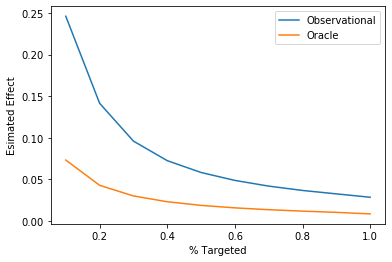

In [226]:
def plot_estimates(e_df, title):
    e_df = e_df.sort_values('pred', ascending=False)
    cum_per = np.arange(e_df.shape[0]) / e_df.shape[0]
    fractions = []
    effects = []
    size = 10
    for i in range(size):
        targeted = cum_per < (i+1)/size
        fraction = targeted.mean()
        estim_effect = e_df[targeted].pred.mean()
        fractions.append(fraction)
        effects.append(estim_effect)
    plt.plot(fractions, effects, label=title)
    plt.xlabel("% Targeted")
    plt.ylabel("Esimated Effect")
    plt.legend()

eval_df['pred'] = obs_preds
plot_estimates(eval_df, "Observational")
eval_df['pred'] = oracle_preds
plot_estimates(eval_df, "Oracle")
plt.show()

# Approach 3: What if there is some experimental data?

Compare each other. Experimental does better.

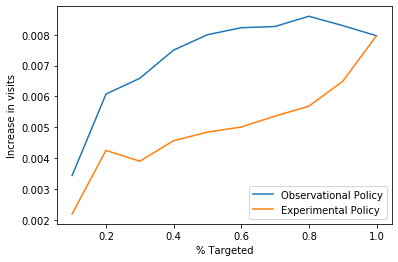

In [215]:
X = exp_df[limited_features + ['treatment']].rename(columns={"treatment":"treated"})
y =  exp_df.visit
exp_cross_preds = cross_val_predict(CausalTree(min_samples_leaf=exp_tree.min_samples_leaf, random_state=42), X, y, cv=10)

copy_exp_df = exp_df.copy()

copy_exp_df['pred'] = obs_tree.predict(copy_exp_df[limited_features])
evaluate(copy_exp_df, "Observational Policy")

copy_exp_df['pred'] = exp_cross_preds
evaluate(copy_exp_df, "Experimental Policy")

Real evaluation set

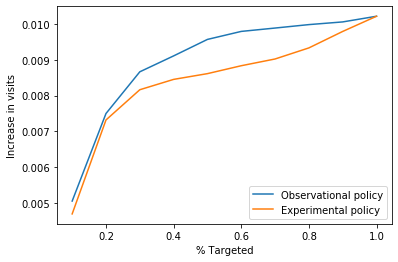

In [216]:
eval_df['pred'] = obs_preds
evaluate(eval_df, "Observational policy")
eval_df['pred'] = exp_preds
evaluate(eval_df, "Experimental policy")
plt.show()

# Approach 4: Benefit vs. cost in experimentation

In [ ]:
# Estimate improvement in decision making for different sizes
# Estimate minimum inference set size for those cases in which the improvement is positive
# Given the curve above, assuming we have a fixed size of X, the experiment is not profitable if too small, or too large. 

In [256]:
min_percentile = 0.3

def get_avg_benefit(e_df):
    e_df = e_df.sort_values('pred', ascending=False)
    targeted = np.arange(e_df.shape[0]) / e_df.shape[0] < min_percentile 
    fraction = targeted.mean()
    avg_outcomes = e_df[targeted].groupby('treatment').visit.mean()
    additional_visits = (avg_outcomes.loc[1] - avg_outcomes.loc[0]) * fraction
    additional_visits = round((additional_visits*visit_value)*total_impressions)
    print(f"Additional visits: {additional_visits:,}")
    return additional_visits
    
print("Observational")
eval_df['pred'] = obs_preds
obs_benefit = get_avg_benefit(eval_df)
    
for sample_size in [50000, 100000, 250000, 500000, 1000000, 2000000, 4000000, df_train.shape[0]]:    
    print(sample_size)
    df_sample = df_train.sample(sample_size, random_state=42)
    sample_tree = fit_causal_tree(df_sample, min_samples_leaf=exp_tree.min_samples_leaf, tune=False)
    eval_df['pred'] = sample_tree.predict(eval_df[limited_features])
    sample_benefit = get_avg_benefit(eval_df)
    print(f"Improvement: {sample_benefit - obs_benefit}")
    print("------------------")

Observational
Additional visits: 4,333.0
50000
--- Time to fit (and tune) causal tree 0.0807797908782959 seconds ---
Additional visits: 4,180.0
Improvement: -153.0
------------------
100000
--- Time to fit (and tune) causal tree 0.3410522937774658 seconds ---
Additional visits: 4,186.0
Improvement: -147.0
------------------
250000
--- Time to fit (and tune) causal tree 1.1873548030853271 seconds ---
Additional visits: 4,292.0
Improvement: -41.0
------------------
500000
--- Time to fit (and tune) causal tree 3.4885988235473633 seconds ---
Additional visits: 4,276.0
Improvement: -57.0
------------------
1000000
--- Time to fit (and tune) causal tree 8.497629165649414 seconds ---
Additional visits: 4,327.0
Improvement: -6.0
------------------
2000000
--- Time to fit (and tune) causal tree 22.634382247924805 seconds ---
Additional visits: 4,303.0
Improvement: -30.0
------------------
4000000
--- Time to fit (and tune) causal tree 56.175174713134766 seconds ---
Additional visits: 4,498.0
I

# Setup

* Domain Knowledge: Do we know anything about the nature of the confounding? In the advert